<a href="https://colab.research.google.com/github/ady-100/Noise-in-Nanofluidics/blob/main/calculating-power-spectra-no-widgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backend
Functions used to calculate analytical PSDs.

In [ ]:
# @title Imports  {"display-mode":"form"}

import numpy as np
import cmath
import matplotlib.pyplot as plt
from dataclasses import dataclass
import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
# @title Analytical Calculations  {"display-mode":"form"}

def PSDCalcs(parameters, fittype):

    '''
    Parameters
    ----------
    nx : number of particles
    ns : number of steps
    nsubs : number of substeps
    dt : timestep in us
    L : system length in nm
    L0 : channel length in nm
    D : diffusion coefficient in nm^2/us
    kon : adsorption rate
    koff : desorption rate

    '''

    nx = parameters[0]
    # ns = parameters[1]
    dt = parameters[2]
    L = parameters[3]
    L0 = parameters[4]
    D = parameters[5]
    kon = parameters[6]
    koff = parameters[7]

    tplots = np.logspace(1, 7, 60)

    r = kon/koff
    Z = L + L0*r
    p0 = 1/Z
    q0 = r/Z

    lscale = parameters[4]

    if fittype=='no_diffusion':
        _ads_time = 2*np.pi/parameters[6]
        _des_time = 2*np.pi/parameters[7]
        tscale = 1/((1/_ads_time+1/_des_time)/2)
        result = lambda s: -nx*L0*q0*koff/(s*(s+kon+koff))
        result = lambda s: -nx*L0*p0*kon/(s*(s+kon+koff))

        Freqs = []
        Sf = []

        for t in tplots:
            f = 1/(t*dt)
            s = 2*np.pi*f*cmath.sqrt(-1)

            nresult = result(s)
            Sf.append(4*np.real(nresult))
            Freqs.append(f*tscale)

        return Freqs, [d/tscale for d in Sf]

    m0 = lambda s: np.sqrt(s/D)
    m1 = lambda s: np.sqrt(s*(s+koff+kon)/(D*(s+koff)))

    tscale = parameters[4]**2/(2*parameters[5])

    if fittype=='all':
        f1 = lambda s: nx*m1(s)*(koff*(p0+q0)+p0*s)/(m0(s)*s*(koff+kon+s))
        t1 = lambda s: np.exp(-L0*m0(s))-np.exp(-L*m0(s))
        t2 = lambda s: np.exp(-L0*m1(s))-1
        b1 = lambda s: (m0(s)-m1(s))*(np.exp(-L0*m0(s)-L0*m1(s))-np.exp(-L*m0(s)))
        b2 = lambda s: (m0(s)+m1(s))*(np.exp(-L0*m0(s))-np.exp(-L0*m1(s)-L*m0(s)))

        result = lambda s: f1(s)*t1(s)*t2(s)/(b1(s)+b2(s))

        Freqs = []
        Sf = []

        for t in tplots:
            f = 1/(t*dt)
            s = 2*np.pi*f*cmath.sqrt(-1)

            nresult = result(s)
            Sf.append(8*np.real(nresult))
            Freqs.append(f*tscale)

        return Freqs, [d/tscale for d in Sf]

    if fittype=='on':
        f1 = lambda s: nx*koff*q0*L0/(s*(kon+koff+s))
        f2 = lambda s: 2*nx*kon*m0(s)*koff*q0/(m1(s)*(s+koff)*(s+koff+kon)*s)
        t1 = lambda s: np.exp(-L0*m0(s))-np.exp(-L*m0(s))
        t2 = lambda s: np.exp(-L0*m1(s))-1
        b1 = lambda s: (m0(s)-m1(s))*(np.exp(-L0*m0(s)-L0*m1(s))-np.exp(-L*m0(s)))
        b2 = lambda s: (m0(s)+m1(s))*(np.exp(-L0*m0(s))-np.exp(-L0*m1(s)-L*m0(s)))

        result = lambda s: -f1(s)+f2(s)*t1(s)*t2(s)/(b1(s)+b2(s))

        Freqs = []
        Sf = []

        for t in tplots:
            f = 1/(t*dt)
            s = 2*np.pi*f*cmath.sqrt(-1)

            nresult = result(s)
            Sf.append(4*np.real(nresult))
            Freqs.append(f*tscale)

        return Freqs, [d/tscale for d in Sf]

    if fittype=='off':
        f1 = lambda s: nx*kon*L0*p0/(s*(s+kon+koff))
        f2 = lambda s: 2*nx*p0*m0(s)*(s+koff)/(m1(s)*s*(s+koff+kon))
        t1 = lambda s: np.exp(-L0*m0(s))-np.exp(-L*m0(s))
        t2 = lambda s: np.exp(-L0*m1(s))-1
        b1 = lambda s: (m0(s)-m1(s))*(np.exp(-L0*m0(s)-L0*m1(s))-np.exp(-L*m0(s)))
        b2 = lambda s: (m0(s)+m1(s))*(np.exp(-L0*m0(s))-np.exp(-L0*m1(s)-L*m0(s)))

        result = lambda s: f2(s)*t1(s)*t2(s)/(b1(s)+b2(s))-f1(s)

        Freqs = []
        Sf = []

        for t in tplots:
            f = 1/(t*dt)
            s = 2*np.pi*f*cmath.sqrt(-1)

            nresult = result(s)
            Sf.append(4*np.real(nresult))
            Freqs.append(f*tscale)

        return Freqs, [d/tscale for d in Sf]

In [ ]:
# @title Plotting Function  {"display-mode":"form"}

def plot_psd(parameters, total_colour, bound_colour, free_colour):
  colors = {
    'total': total_colour,
    'bound': bound_colour,
    'free': free_colour,
    't_sys': '#707070',
    't_cha': '#b8b8b8',
    't_ads': '#707070',
    't_des': '#b8b8b8',
  }

  line_styles = {
    'total': '-',
    'bound': '-',
    'free': '-',
    't_sys': 'dotted',
    't_cha': 'dotted',
    't_ads': 'dashed',
    't_des': 'dashed',
  }

  lw = {
    'curves': 5,
    'vlines': 2,
  }

  alp = 1

  if parameters[6] == 0:
    _diffusive_system_time = parameters[3]**2/(2*parameters[5])
    _diffusive_channel_time = parameters[4]**2/(2*parameters[5])
    tscale = parameters[4]**2/(2*parameters[5])
    diffusive_system_time = _diffusive_system_time/tscale
    diffusive_channel_time = _diffusive_channel_time/tscale
    f, psd = PSDCalcs(parameters, 'all')
    fig, ax1 = plt.subplots(num=1)
    ax1.axvline(x=1/diffusive_system_time, label='$t_{sys}$', color=colors['t_sys'], linestyle=line_styles['t_sys'], lw=lw['vlines'], alpha=alp)
    ax1.axvline(x=1/diffusive_channel_time, label='$t_{cha}$', color=colors['t_cha'], linestyle=line_styles['t_cha'], lw=lw['vlines'], alpha=alp)
    ax1.loglog(f, psd, color=colors['total'], linestyle=line_styles['total'], label='total', lw=lw['curves'])

  if parameters[5] == 0:
    _adsorption_time = 1/parameters[6]
    _desorption_time = 1/parameters[7]
    tscale = 1/((1/_adsorption_time+1/_desorption_time)/2)
    adsorption_time = _adsorption_time/tscale
    desorption_time = _desorption_time/tscale
    fon, psdon = PSDCalcs(parameters, 'no_diffusion')
    fig, ax1 = plt.subplots(num=1)
    ax1.axvline(x=1/adsorption_time, label='$t_{ads}$', color=colors['t_ads'], linestyle=line_styles['t_ads'], lw=lw['vlines'], alpha=alp)
    ax1.axvline(x=1/desorption_time, label='$t_{des}$', color=colors['t_des'], linestyle=line_styles['t_des'], lw=lw['vlines'], alpha=alp)
    ax1.loglog(fon, psdon, color=colors['free'], linestyle=line_styles['free'], label='free', lw=lw['curves'])

  if parameters[6] != 0 and parameters[5] != 0:
    _diffusive_system_time = parameters[3]**2/(2*parameters[5])
    _diffusive_channel_time = parameters[4]**2/(2*parameters[5])
    _adsorption_time = 1/parameters[6]
    _desorption_time = 1/parameters[7]
    tscale = parameters[4]**2/(2*parameters[5])
    diffusive_system_time = _diffusive_system_time/tscale
    diffusive_channel_time = _diffusive_channel_time/tscale
    adsorption_time = _adsorption_time/tscale
    desorption_time = _desorption_time/tscale
    f, psd = PSDCalcs(parameters, 'all')
    fon, psdon = PSDCalcs(parameters, 'on')
    foff, psdoff = PSDCalcs(parameters, 'off')
    fig, ax1 = plt.subplots(num=1)
    ax1.axvline(x=1/diffusive_system_time, label='$t_{sys}$', color=colors['t_sys'], linestyle=line_styles['t_sys'], lw=lw['vlines'], alpha=alp)
    ax1.axvline(x=1/diffusive_channel_time, label='$t_{cha}$', color=colors['t_cha'], linestyle=line_styles['t_cha'], lw=lw['vlines'], alpha=alp)
    ax1.axvline(x=1/adsorption_time, label='$t_{ads}$', color=colors['t_ads'], linestyle=line_styles['t_ads'], lw=lw['vlines'], alpha=alp)
    ax1.axvline(x=1/desorption_time, label='$t_{des}$', color=colors['t_des'], linestyle=line_styles['t_des'], lw=lw['vlines'], alpha=alp)
    ax1.loglog(fon, psdon, color=colors['bound'], linestyle=line_styles['bound'], label='bound', lw=lw['curves'])
    ax1.loglog(foff, psdoff, color=colors['free'], linestyle=line_styles['free'], label='free', lw=lw['curves'])
    ax1.loglog(f, psd, color=colors['total'], linestyle=line_styles['total'], label='total', lw=lw['curves'])

  ax1.legend(loc='lower left')
  ax1.grid(which='major', color='lightgrey', linewidth=0.8)
  ax1.grid(which='minor', color='gainsboro', linestyle=':', linewidth=0.5)
  ax1.set_xlabel('Frequency')
  ax1.set_ylabel('PSD')

In [ ]:
# @title Dataclass  {"display-mode":"form"}

@dataclass
class SimulationParams:
    def __init__(self, nx, ns, dt, L, L0, D, kon, koff):
        self.nx = nx
        self.ns = ns
        self.dt = dt
        self.L = L
        self.L0 = L0
        self.D = D
        self.kon = kon
        self.koff = koff

    def to_list(self):
        return [self.nx, self.ns, self.dt, self.L, self.L0, self.D, self.kon, self.koff]

# Sandbox
Play around with different parameters to see how this changes the power spectra of number fluctuations (total, free, bound) in the channel.

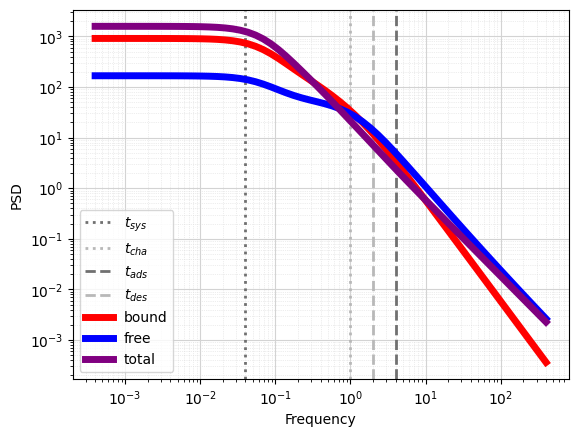

In [16]:
# Define simulation parameters here
# Format: [nx, ns, dt, L, L0, D, kon, koff]
parameters = [
    1000,   # nx: number of particles
    10000,  # ns: number of steps
    0.01,   # dt: timestep in us
    1000,   # L: system length in nm
    200,    # L0: channel length in nm
    500,    # D: diffusion coefficient in nm^2/us
    0.1,    # kon: adsorption rate
    0.05    # koff: desorption rate
]

# Set colors for plot lines (hex or named colors)
total_colour = '#800080'  # purple
bound_colour = '#FF0000'  # red
free_colour = '#0000FF'   # blue

# Plot the PSDs
plot_psd(parameters, total_colour, bound_colour, free_colour)
